In [1]:
!pip uninstall kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!ls -lha kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Uninstalling kaggle-1.5.10:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.7/dist-packages/kaggle-1.5.10.dist-info/*
    /usr/local/lib/python3.7/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 5.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=11edad3a01e164e92e547aede59c31a46ce7218ea7c86cc6c66d5b19ba1d3d09
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
-rw-r--r-- 1 root root 65 Mar 18 01:28 kaggle.json


In [2]:
!kaggle competitions download -c sejong-ai-challenge-p2
!unzip sejong-ai-challenge-p2.zip

 57% 17.0M/29.8M [00:00<00:00, 68.4MB/s]
100% 29.8M/29.8M [00:00<00:00, 95.7MB/s]
Archive:  sejong-ai-challenge-p2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(nltk.corpus.stopwords.words('english'))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train.head(4)

,Unnamed: 0,Text,Label
0,252571,"Great price and quick service, the product is ...",1
1,216109,I just purchased the Samsung Galaxy Note 3 fro...,0
2,79523,DO NOT BUY THE CHARGER IS NOT A FAST CHARGING ...,0
3,231236,This is phone is not worth the price. This pho...,0


In [5]:
grouped_df = train.groupby('Label') #라벨별로 묶어서 그 라벨의 특징 알아보기 위함

print(grouped_df.size()) # ==> 0, 1 데이터 개수 비슷함

print('---------------------')

for label, group in grouped_df:
    print('label: ', label)
    cnt= 0
    for ind, row in group.iterrows(): #행 별로 받아오기
        print(row['Text'])
        cnt+=1
        if cnt==10:
            break
    print('\n')

Label
0    97192
1    96948
dtype: int64
---------------------
label:  0
I just purchased the Samsung Galaxy Note 3 from a local Verizon store. I am very disappointed with this phone. I paid full price to keep my unlimited data alive. I am finding that the RF reception is abysmal. In buildings where I used to get -89 dbm with my Motorola Droid Bionic, I get -118 dbm with the Samsung Galaxy Note 3. Even outdoors, with the Samsung Galaxy Note 3, I don't get that great of a 4G LTE signal. The phone will usually then switch to 1 to 2 bars of 3G and stay there until I am back in a really strong 4G area. I'm thinking either the antenna is of poor quality or the radio is not very sensitive - or both. I may have to return this phone and try the LG G2. This GN3 cannot even begin to compete with my old Motorola Droid Bionic when it comes to holding on to a less than perfect signal.  In strong signal areas there is no problem, but when the signal isn't the best, the GN3 does a poor job of holding

# Feature engeneering

In [6]:
# 단어 총 개수
train['num_words'] = train['Text'].apply(lambda x : len(str(x).split()))
test['num_words'] = test['Text'].apply(lambda x : len(str(x).split()))

# 문장 길이
train['len_text'] = train['Text'].apply(lambda x: len(str(x)))
test['len_text'] = test['Text'].apply(lambda x: len(str(x)))

#불용어 개수
train['num_stopwords'] = train['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test['num_stopwords'] = test['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#구두점 개수
train['num_punc'] =train['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['num_punc'] =test['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#대문자 개수 
train['num_upper'] = train['Text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test['num_upper'] = test['Text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#문장 평균 단어 개수
train['mean_word_len'] = train['Text'].apply(lambda x:np.mean([len(w) for w in str(x).split()]))
test['mean_word_len'] = test['Text'].apply(lambda x:np.mean([len(w) for w in str(x).split()]))


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [7]:
train = train.drop(['Unnamed: 0'], axis=1)
train.head(10)

,Text,Label,num_words,len_text,num_stopwords,num_punc,num_upper,mean_word_len
0,"Great price and quick service, the product is ...",1,34,185,16,4,1,4.470588
1,I just purchased the Samsung Galaxy Note 3 fro...,0,301,1523,141,37,28,4.039867
2,DO NOT BUY THE CHARGER IS NOT A FAST CHARGING ...,0,14,69,7,1,14,4.000000
3,This is phone is not worth the price. This pho...,0,76,387,38,15,4,4.105263
4,Doesn't lay flat on the screen. Put it on in t...,0,36,178,20,4,0,3.972222
5,"Should have really looked at the dimensions, i...",1,18,107,10,4,0,4.944444
6,The case is great but is a bit slippery.,1,9,40,5,1,0,3.555556
7,I purchased a Droid 2x almost 2 years ago. Ove...,0,102,577,42,8,1,4.666667
8,"It's a good thing I got the three-pack, becaus...",1,179,989,80,41,4,4.513966
9,Bounced around on my cd slot. Seemed loose so...,0,50,249,26,6,4,3.960000


In [8]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2021-03-18 01:30:17--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-03-18 01:30:17--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-03-18 01:30:17--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [9]:
import tqdm
from nltk import word_tokenize

def load_glove_index():
    EMBEDDING_FILE = 'glove.840B.300d.txt'

    def get_coefs(word, *arr) :
        return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*n.split(' ')) for n in open(EMBEDDING_FILE))
    return embeddings_index

embedding_index = load_glove_index()

print('Found %s word vectors.' % len(embedding_index))

# embedding_index : 단어 벡터 embedding

# 임베딩 개념 좀 더 알자 . . . 

def sent2vec(s): #문장을 벡터화

    words = str(s).lower() # 토큰화 시키기 위해서 다 소문자로 변환 
    words = word_tokenize(words) # 토큰화 시켜줌
    words = [w for w in words if not w in eng_stopwords] # 불용어 아닌 것들만 저장
    words = [w for w in words if w.isalpha()] #???
    M = []

    for w in words :
        try:
            M.append(embedding_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# glove feature 생성

x_train_glove = np.array([sent2vec(x) for x in tqdm.tqdm(train['Text'])])
x_test_glove = np.array([sent2vec(x) for x in tqdm.tqdm(test['Text'])])

train = pd.concat([train, pd.DataFrame(x_train_glove)], axis=1)
test = pd.concat([test, pd.DataFrame(x_test_glove)], axis=1)


  0%|          | 142/194140 [00:00<02:17, 1412.49it/s]

Found 2196016 word vectors.


100%|██████████| 83204/83204 [00:53<00:00, 1553.72it/s]


In [10]:
y_train = train['Label']
x_train = train.drop(['Label', 'Text'], axis=1)
x_test = test.drop(['Text','Unnamed: 0'], axis=1)

x_test

,num_words,len_text,num_stopwords,num_punc,num_upper,mean_word_len,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,13,60,7,3,0,3.692308,-0.027584,0.055922,-0.042056,-0.019853,-0.017597,0.003937,0.000087,-0.131539,0.007952,0.564692,-0.023108,0.046744,0.024691,-0.024636,-0.138805,-0.011043,-0.051208,0.201133,0.006123,0.022247,-0.038335,-0.009055,-0.025978,-0.014879,-0.004329,0.000984,-0.004538,-0.043072,0.009377,-0.004836,0.018832,0.015215,0.011344,-0.012175,...,0.034425,0.043334,-0.041534,0.066906,0.009717,0.030007,-0.008179,0.044770,-0.020427,0.001669,0.002192,-0.008515,-0.003501,-0.080982,-0.024382,0.017162,-0.006317,0.032805,-0.015798,-0.012634,-0.002312,0.060391,-0.016746,-0.049226,-0.005730,0.006223,0.028485,0.012311,-0.046570,0.016074,-0.066731,0.018258,0.014561,0.041014,0.051915,-0.025345,0.003520,-0.066888,0.018736,0.046927
1,24,124,9,4,0,4.208333,-0.040205,0.017771,-0.049756,-0.039940,-0.023006,-0.047138,-0.021079,-0.057115,0.009266,0.592762,-0.045899,0.052346,-0.001132,-0.018669,-0.035396,-0.027843,-0.007002,0.276158,-0.000303,0.025002,-0.001585,-0.013483,0.044025,0.018922,-0.008416,-0.041512,-0.043159,-0.066129,0.014406,-0.056889,-0.021831,-0.004840,0.000558,0.021570,...,0.053776,0.054594,-0.013826,0.011357,0.039036,0.011915,-0.035730,0.021212,0.033467,-0.013881,0.048012,-0.011595,-0.019975,-0.056736,-0.020131,-0.027371,0.003260,0.006253,0.018753,-0.007089,-0.025065,0.019793,-0.025629,0.021698,0.022122,-0.005200,0.048553,-0.026725,-0.029531,0.029016,-0.072502,-0.014878,0.012084,-0.007016,-0.001803,0.030760,-0.013808,-0.023882,0.002639,0.034170
2,8,38,5,1,0,3.875000,-0.060125,0.055832,-0.071329,-0.024247,-0.060454,-0.001318,-0.014908,-0.063776,0.004183,0.576182,-0.058892,0.060335,0.027397,0.013601,-0.043451,-0.006144,-0.014522,0.240395,-0.024465,0.021014,0.024386,0.004354,-0.040127,-0.029488,-0.026787,-0.033544,-0.033304,-0.071218,0.038996,-0.033090,-0.043578,-0.031321,0.020311,0.032922,...,0.012798,0.068733,0.030824,0.047286,0.044233,-0.010110,0.021325,0.009625,0.130917,-0.010406,0.086598,0.012744,-0.001253,-0.030803,-0.042304,0.015038,-0.055509,0.024365,0.053269,0.067642,-0.005357,0.004956,0.012080,0.078514,-0.031013,-0.030319,0.024653,-0.012894,-0.015034,0.026101,-0.072856,0.013392,0.038882,0.001392,0.063238,-0.064555,-0.006761,0.012692,0.062703,0.050050
3,43,222,19,3,3,4.186047,-0.015913,0.038141,-0.047987,-0.014827,0.014806,-0.037465,0.030925,-0.085454,0.020279,0.583555,-0.008572,-0.010740,0.041522,-0.031071,-0.052861,-0.010804,-0.058010,0.306181,0.004187,-0.013671,-0.067531,-0.015116,-0.023286,-0.037470,-0.009613,0.043611,-0.031865,-0.050560,0.002179,-0.040134,-0.022280,-0.030159,-0.003064,0.010666,...,0.025779,0.036055,-0.017867,0.040600,0.006557,0.047337,0.024673,-0.002908,0.006547,0.042430,-0.019595,0.004157,0.009044,-0.039864,-0.023385,0.014339,0.012424,0.007638,-0.026802,0.023007,-0.013007,0.050287,0.060092,-0.001999,0.011940,0.011069,0.001586,0.017956,-0.027605,-0.003680,-0.077788,0.016343,0.038243,-0.002950,0.058982,-0.022048,0.024075,-0.002651,0.028024,0.007246
4,150,781,73,21,7,4.193333,0.001738,0.047621,-0.058922,-0.001755,0.035976,-0.029438,-0.033635,-0.051207,-0.008109,0.578808,0.007516,0.003286,0.023954,-0.040277,-0.066636,-0.014994,-0.036784,0.417160,-0.008826,-0.023484,-0.047003,0.015070,-0.004530,0.005128,0.001312,-0.009728,-0.016439,-0.026747,0.002436,-0.031975,0.000354,0.008591,-0.024351,-0.005504,...,0.063492,0.051463,-0.019245,0.003600,0.015891,0.010896,-0.012741,0.010516,0.049900,-0.003040,0.007169,0.007923,-0.010666,-0.068973,-0.017279,-0.005279,0.001887,0.013498,-0.000186,-0.003719,0.013043,0.038270,-0.009777,0.006317,-0.022690,-0.038121,0.007764,0.012696,-0.005213,-0.017673,-0.083501,0.027283,0.018792,-0.012875,-0.005108,0.006876,-0.011996,-0.006714,0.008657,0.025271
...,...,...,...

In [11]:
def runXGB(x_train, y_train, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 2
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 500

    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [12]:
from sklearn import metrics, model_selection

kf = model_selection.KFold(n_splits=5, shuffle=True)
cv_scores=[]
pred_full_test=0
pred_train = np.zeros([train.shape[0], 2])

for dev_index, val_index in kf.split(x_train):

    x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
    y_dev, y_val = y_train.loc[dev_index], y_train.loc[val_index]
    y_val_pred, y_test_pred, model = runXGB(x_dev, y_dev, x_val, y_val, x_test, seed_val=0)

    pred_full_test = pred_full_test + y_test_pred
    pred_train[val_index, :] = y_val_pred
    cv_scores.append(metrics.log_loss(y_val,y_val_pred))
    break

print('cv scores: ', cv_scores)

[0]	train-mlogloss:0.676932	test-mlogloss:0.676774
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.511623	test-mlogloss:0.511231
[40]	train-mlogloss:0.457081	test-mlogloss:0.457082
[60]	train-mlogloss:0.428849	test-mlogloss:0.429941
[80]	train-mlogloss:0.411097	test-mlogloss:0.413494
[100]	train-mlogloss:0.398104	test-mlogloss:0.401575
[120]	train-mlogloss:0.388283	test-mlogloss:0.392917
[140]	train-mlogloss:0.380316	test-mlogloss:0.386084
[160]	train-mlogloss:0.373683	test-mlogloss:0.380378
[180]	train-mlogloss:0.368019	test-mlogloss:0.375699
[200]	train-mlogloss:0.36315	test-mlogloss:0.371752
[220]	train-mlogloss:0.358668	test-mlogloss:0.368267
[240]	train-mlogloss:0.354572	test-mlogloss:0.365093
[260]	train-mlogloss:0.350998	test-mlogloss:0.362541
[280]	train-mlogloss:0.347627	test-mlogloss:0.360011
[300]	train-mlogloss:0.344345	test-mlogloss:0.357605
[320]	tr

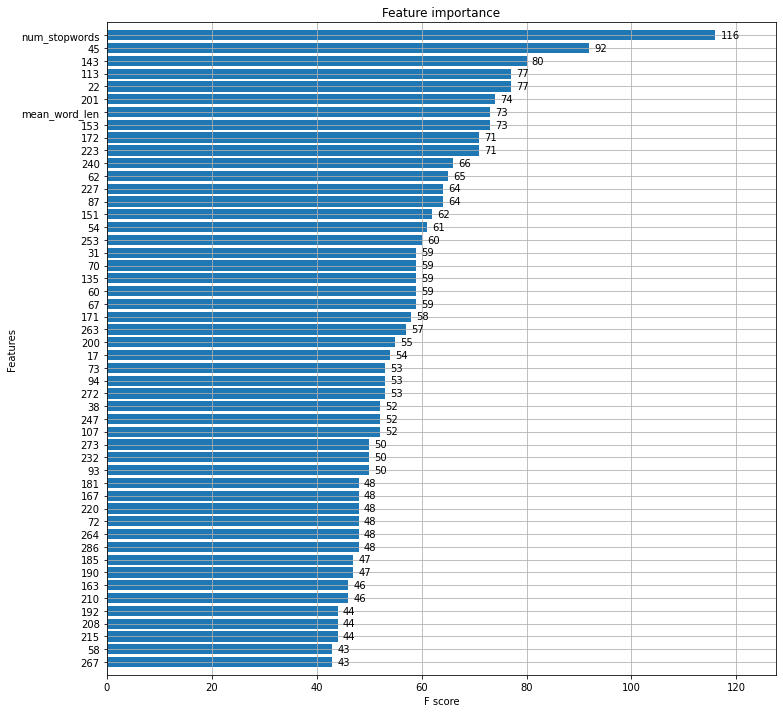

In [34]:
#plot the important variables

fig, ax = plt.subplots(figsize = (12,12))

xgb.plot_importance(model, max_num_features= 50, height = 0.8, ax = ax)
plt.show()

In [32]:
for i in range(len(y_val_pred)):
    submission['Label'][i] = y_val_pred[i].argmax()

submission.to_csv('submission.csv', index=None)

In [33]:
!kaggle competitions submit -c sejong-ai-challenge-p2 -f submission.csv -m "Message"

100% 639k/639k [00:00<00:00, 2.63MB/s]
Successfully submitted to Sejong AI Challenge 문제2

In [ ]:
## 0.71871